# Udacity Nanaodegree Program "Self Driving Car Engineer"
## Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.



#### Import required modules

In [ ]:
from skimage.feature import hog
from sklearn import svm, grid_search
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.measurements import label
import cv2
import glob
import imp
import matplotlib.image as mpimg
import matplotlib.pyplot as plt 
from moviepy.editor import VideoFileClip
import numpy as np
import os
import pickle
import random
import time
%matplotlib inline


#### Find Training Images

In [ ]:
car_img_names =  glob.glob("training_data/cars/*/*")
notcar_img_names = glob.glob("training_data/notcars/*/*")
print("training images - cars:", len(car_img_names), "   notcars:", len(notcar_img_names))

#### Define a functions to convert the colorspace of an image and to get the hog features
This code was taken from the lesson materials

In [ ]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    print("Error: Color space {:s} is not supported!".format(conv))
    return None

    
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features


#### Define a function to extract hte HOG features from an array of car images and non-car images
This code was taken from the lesson materials

In [ ]:
# Define a function to extract features from a list of images
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if False:
                feature_image = convert_color(image, "RGB2"+color_space)
            else:
                if color_space == 'HSV':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
#                elif color_space == 'LUV':
#                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
#                elif color_space == 'HLS':
#                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
#                elif color_space == 'YUV':
#                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
                elif color_space == 'YCrCb':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


#### Extract the feature from the training images and combine them with the appropriate labels

In [ ]:
# Feature extraction
# COLORSPACE is one out of "BGR", "HSV", "LUV", "HLS", "YUV", "YCrCb"
COLORSPACE = "YCrCb"
# HOG extraction parameters
ORIENTATION = 9
PIX_PER_CELL = 8
CELL_PER_BLOCK = 2
# HOG_CHANNEL is one out of 0, 1, 2, "ALL"
HOG_CHANNEL = "ALL"
HIST_FEAT = False
SPATIAL_FEAT = False

print("HOG parameters: orient:", ORIENTATION, " pix_per_cell:", PIX_PER_CELL, " cell_per_block:", CELL_PER_BLOCK, " channel:", HOG_CHANNEL)

t0 = time.time()
car_features = extract_features(car_img_names, color_space=COLORSPACE, orient=ORIENTATION,
                                pix_per_cell=PIX_PER_CELL, cell_per_block=CELL_PER_BLOCK,
                                hog_channel=HOG_CHANNEL, 
                                hist_feat=HIST_FEAT, spatial_feat=SPATIAL_FEAT)

notcar_features = extract_features(notcar_img_names, color_space=COLORSPACE, orient=ORIENTATION,
                                pix_per_cell=PIX_PER_CELL, cell_per_block=CELL_PER_BLOCK,
                                hog_channel=HOG_CHANNEL, 
                                hist_feat=HIST_FEAT, spatial_feat=SPATIAL_FEAT)
print("Seconds to extract HOG features: {:.3f}".format(time.time()-t0))

# Combine car features and non-car features into one array
X = np.vstack([car_features, notcar_features])

# Create the labels vector
labels = np.hstack([np.ones(len(car_img_names)), np.zeros(len(notcar_img_names))])

print("X.shape:", X.shape)

#### Shuffle and split the data and train the classifier

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size = 0.2,
                                                    random_state=np.random.randint(0, 100))

# Use a linear SVC as classifier
clf = svm.LinearSVC()

t0 = time.time()
clf.fit(X_train, y_train)
print("Seconds to train the classifier: {:.3f}".format(time.time()-t0))

# Check that accuracy of the classifier
acc = accuracy_score(y_test, clf.predict(X_test))
print("Accuracy of the classifier: {:.3f}%".format(acc*100))


#### Define a function to detect the cars
This code was partly taken form the lesson materials

In [155]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, spatial_size=(32, 32), hist_bins=32, show_boxes=False):

    if True: #show_boxes:
        colors = [(0,0,255), (0,255,255), (0,255,0), (255,255,0), (255,0,0), (255,0,255), (255,255,255)]
#    print("orient:", orient, " pix/cell:", pix_per_cell, " cell/block:", cell_per_block) #, " spatial:", spatial_size, " bins:", hist_bins)
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv="RGB2"+color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    boxes = []
    for xb in range(nxsteps+1):
        for yb in range(nysteps+1):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

######### Spatial features and color histograms are not used
            # Extract the image patch
#            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
 
#            # Get color features
#            spatial_features = bin_spatial(subimg, size=spatial_size)
#            hist_features = color_hist(subimg, nbins=hist_bins)

#            # Scale features and make a prediction
#            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
#            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))
#            test_prediction = svc.predict(test_features)

            test_prediction = svc.predict(hog_features)

            xbox_left = np.int(xleft*scale)
            ybox_top = np.int(ytop*scale) + ystart
            ytop_draw = np.int(ytop*scale)
            win_size = np.int(window*scale)

            if show_boxes:
#                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_size,ytop_draw+win_size+ystart),(0,0,255),6) 
                cv2.rectangle(draw_img,(xbox_left, ybox_top),(xbox_left+win_size,ybox_top+win_size),colors[yb],3) 

            if test_prediction == 1:
                boxes.append([xbox_left, ybox_top, win_size])
    if show_boxes:
        return np.array(boxes), draw_img
    else:
        return np.array(boxes)


#### Load a test image and find the cars

In [180]:
def apply_threshold(heatmap, value):
    heatmap[heatmap < value] = 0
    return heatmap

heatmap_smooth = None

def process_img(img):
    global heatmap_smooth
    img_out = np.copy(img)
    heatmap = np.zeros_like(img[:,:,0])
    boxes = []
    cars = []

    scale_dim = {1.0: (400, 492),
                 1.5: (400, 528),
                 2.0: (400, 560),
                 2.5: (400, 600),
                 3.0: (400, 592),
                }

    for s in scale_dim:
        found = find_cars(img, scale_dim[s][0], scale_dim[s][1], s, 
                               svc=clf, X_scaler=None, color_space=COLORSPACE, 
                               orient=ORIENTATION, pix_per_cell=PIX_PER_CELL, 
                               cell_per_block=CELL_PER_BLOCK)
        if len(found) > 0:
            boxes.append(found)
            
    if len(boxes) > 0:
        for b in np.concatenate(boxes):
            color = COLORS[b[2]]
            cv2.rectangle(img_out, (b[0], b[1]), (b[0]+b[2], b[1]+b[2]), color, 2)
            heatmap[b[1]:b[1]+b[2], b[0]:b[0]+b[2]] += 1

        # Create initial heatmap if it not exists yet
 #       if not hasattr(process_img, "heatmap_smooth"):
 #           print("Init heatmap_smooth")
 #           heatmap_smooth = np.zeros_like(heatmap)
            
        heatmap_smooth *= 5
        heatmap_smooth //= 10
        heatmap_smooth += heatmap

        # Apply threshold to the heat map
        heatmap_thresh = apply_threshold(np.copy(heatmap_smooth), 2)
        # Assign labels
        labels, num_labels = label(heatmap_thresh)

        # Draw bounding rectangles
        img_draw = np.copy(img)
        for car_id in range(1, num_labels+1):
            nonzero = (labels == car_id).nonzero()
            if len(nonzero[0]) > 0:
                nonzerox = np.array(nonzero[1])
                nonzeroy = np.array(nonzero[0])
#                bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
#                cars.append((bbox[0], bbox[1]))

                bbox = ((np.max(nonzerox)+np.min(nonzerox))//2, (np.max(nonzeroy)+np.min(nonzeroy))//2,
                        np.max(nonzerox) - np.min(nonzerox), np.max(nonzeroy) - np.min(nonzeroy))
                cars.append(bbox)
    return cars, heatmap_smooth, img_out
    

Processing took 0.331 seconds
[(879, 463, 159, 127), (1163, 463, 215, 127)]
[(879, 463, 159, 127), (1163, 463, 215, 127)]
<class 'list'>


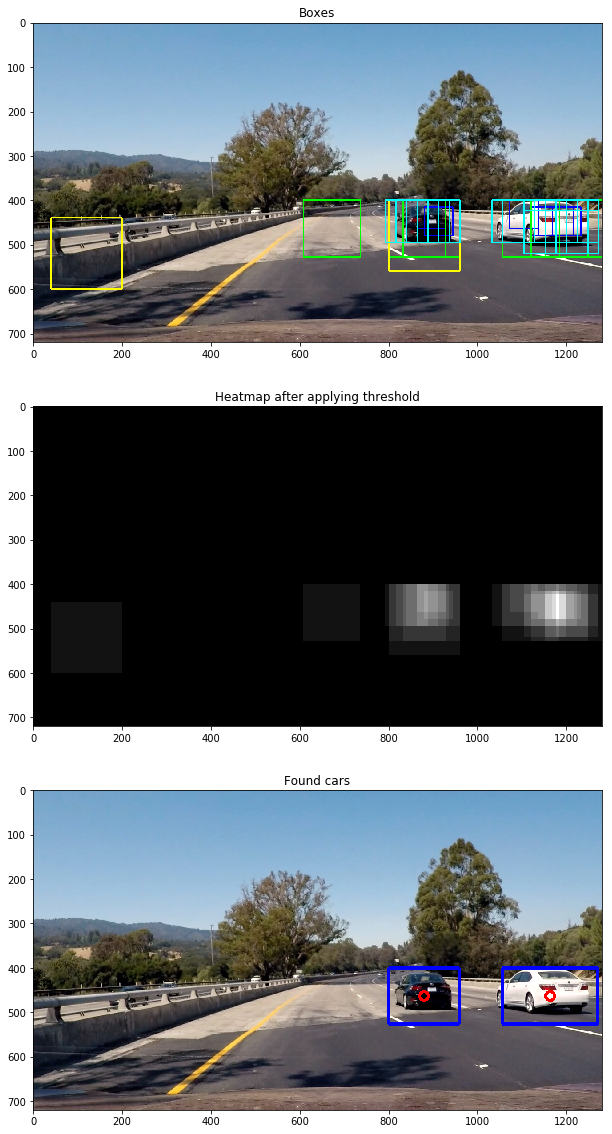

In [199]:
COLORS = { 64: (0,0,255),
           96: (0,255,255),
          128: (0,255,0),
          160: (255,255,0),
          192: (255,0,0)}
#img = mpimg.imread("tmp/project_frame_734.jpg")
img = mpimg.imread("test_images/test4.jpg")

img_draw = np.copy(img)
heatmap_smooth = np.zeros_like(img[:,:,0])

if False:
    found, img_out = find_cars(img, 400, 492, 1.0, 
                           svc=clf, X_scaler=None, color_space=COLORSPACE, 
                           orient=ORIENTATION, pix_per_cell=PIX_PER_CELL, 
                           cell_per_block=CELL_PER_BLOCK, show_boxes=True)
else:
    t0 = time.time()
    cars, heatmap, img_out = process_img(img)  
    print("Processing took {:.3f} seconds".format(time.time()-t0))
    print(cars)
    cars.sort()
    print(cars)
    print(type(cars))
    for c in cars:
        xleft = c[0]-c[2]//2
        xright = c[0]+c[2]//2
        ytop  = c[1]-c[3]//2
        ybottom = c[1]+c[3]//2
        cv2.rectangle(img_draw, (xleft, ytop), (xright, ybottom), (0,0,255), 6)
        cv2.circle(img_draw, (c[0], c[1]), 10, (255,0,0), 6)
#        cv2.rectangle(img_draw, c)[0], c[1], (0,0,255), 6)

f, sub = plt.subplots(3, 1, figsize=(60,20))
sub[0].imshow(img_out)
sub[0].set_title("Boxes")
sub[1].imshow(heatmap, cmap="gray")
sub[1].set_title("Heatmap after applying threshold")
sub[2].imshow(img_draw)
sub[2].set_title("Found cars")

In [217]:
# Select the video: "project" or "test"
video_name = "project"

frame_name = "tmp/{:s}_frame_{:d}.jpg"
frames_to_save = [16, 24, 613, 734, 1046, 1103]

NUM_PREV_CARS = 5

def process_video_frame(img):
    process_video_frame.frame_no += 1
    
    if process_video_frame.frame_no in frames_to_save:
        mpimg.imsave(frame_name.format(video_name, process_video_frame.frame_no), img)
    
    if len(process_video_frame.prev_cars) > NUM_PREV_CARS:
        del process_video_frame.prev_cars[0]

    cars, heatmap, img_out = process_img(img) 
    cars.sort()
    
    filt_cars = []
    for c in cars:
        c_count = 0
        for i in range(len(process_video_frame.prev_cars)):
            prev_cars = process_video_frame.prev_cars[i]
#            pr_int("prev_cars[",i,"]=",prev_cars)
            max_dist = (NUM_PREV_CARS-i)*20
            for pc in prev_cars:
                if (pc[0]-max_dist) < c[0] and c[0] < (pc[0]+max_dist):
                    c_count += 1
                    break
        if c_count < NUM_PREV_CARS:
#            pr_int("c:", c, " -> count:", c_count, " IGNORE")
            pass
        else:
#            pr_int("c:", c, " -> count:", c_count, " USE")
            xleft = c[0]-c[2]//2
            xright = c[0]+c[2]//2
            ytop  = c[1]-c[3]//2
            ybottom = c[1]+c[3]//2
            cv2.rectangle(img, (xleft, ytop), (xright, ybottom), (0,0,255), 6)
#            cv2.circle(img, (c[0], c[1]), 10, (255,0,0), 6)

    process_video_frame.prev_cars.append(cars)

    cv2.putText(img, "Frame: {:d}".format(process_video_frame.frame_no), 
                (50,50), cv2.FONT_HERSHEY_PLAIN, 2, (255, 255, 255))

    small_heatmap = cv2.cvtColor(cv2.resize(np.copy(heatmap)*30, 
                                            (heatmap.shape[1]//2, heatmap.shape[0]//2)),
                                             cv2.COLOR_GRAY2BGR)
    img[0:small_heatmap.shape[0], img.shape[1]-small_heatmap.shape[1]:img.shape[1], :] = small_heatmap
    return img

heatmap_smooth = np.zeros_like(img[:,:,0])

process_video_frame.frame_no = 0
process_video_frame.prev_cars = []
video_out_name = "./output_images/{:s}_video.mp4".format(video_name)
video_in = VideoFileClip("{:s}_video.mp4".format(video_name))
video_out = video_in.fl_image(process_video_frame)
%time video_out.write_videofile(video_out_name, audio=False)


[MoviePy] >>>> Building video ./output_images/project_video.mp4
[MoviePy] Writing video ./output_images/project_video.mp4









  0%|          | 0/1261 [00:00<?, ?it/s]






  0%|          | 1/1261 [00:00<07:08,  2.94it/s]






  0%|          | 2/1261 [00:00<07:12,  2.91it/s]






  0%|          | 3/1261 [00:01<07:03,  2.97it/s]






  0%|          | 4/1261 [00:01<07:05,  2.95it/s]






  0%|          | 5/1261 [00:01<06:58,  3.00it/s]






  0%|          | 6/1261 [00:01<06:52,  3.04it/s]






  1%|          | 7/1261 [00:02<06:53,  3.03it/s]






  1%|          | 8/1261 [00:02<06:48,  3.07it/s]






  1%|          | 9/1261 [00:02<06:47,  3.07it/s]






  1%|          | 10/1261 [00:03<06:47,  3.07it/s]






  1%|          | 11/1261 [00:03<06:44,  3.09it/s]






  1%|          | 12/1261 [00:03<06:45,  3.08it/s]






  1%|          | 13/1261 [00:04<06:43,  3.09it/s]






  1%|          | 14/1261 [00:04<06:41,  3.11it/s]






  1%|          | 15/1261 [00:05<10:08,  2.05it/s]






  1%|▏         | 16/1261 [00:05<09:08,  2.27it/s]






  1%|▏         | 17/1261 [00:06<08:23,  2.47it/s]






  1

  8%|▊         | 106/1261 [00:35<06:20,  3.04it/s]






  8%|▊         | 107/1261 [00:35<06:17,  3.06it/s]






  9%|▊         | 108/1261 [00:35<06:14,  3.08it/s]






  9%|▊         | 109/1261 [00:36<06:13,  3.09it/s]






  9%|▊         | 110/1261 [00:36<06:15,  3.07it/s]






  9%|▉         | 111/1261 [00:36<06:13,  3.08it/s]






  9%|▉         | 112/1261 [00:37<06:17,  3.05it/s]






  9%|▉         | 113/1261 [00:37<06:12,  3.08it/s]






  9%|▉         | 114/1261 [00:37<06:12,  3.08it/s]






  9%|▉         | 115/1261 [00:38<06:18,  3.03it/s]






  9%|▉         | 116/1261 [00:38<06:19,  3.02it/s]






  9%|▉         | 117/1261 [00:38<06:24,  2.97it/s]






  9%|▉         | 118/1261 [00:39<06:23,  2.98it/s]






  9%|▉         | 119/1261 [00:39<06:23,  2.98it/s]






 10%|▉         | 120/1261 [00:39<06:23,  2.98it/s]






 10%|▉         | 121/1261 [00:40<06:23,  2.97it/s]






 10%|▉         | 122/1261 [00:40<06:16,  3.02it/s]






 10%|▉         | 123/1261 [00:4

 17%|█▋        | 211/1261 [01:10<05:53,  2.97it/s]






 17%|█▋        | 212/1261 [01:10<05:50,  2.99it/s]






 17%|█▋        | 213/1261 [01:11<05:50,  2.99it/s]






 17%|█▋        | 214/1261 [01:11<05:49,  2.99it/s]






 17%|█▋        | 215/1261 [01:11<05:49,  2.99it/s]






 17%|█▋        | 216/1261 [01:12<05:47,  3.01it/s]






 17%|█▋        | 217/1261 [01:12<05:47,  3.00it/s]






 17%|█▋        | 218/1261 [01:12<05:46,  3.01it/s]






 17%|█▋        | 219/1261 [01:13<05:46,  3.01it/s]






 17%|█▋        | 220/1261 [01:13<05:43,  3.03it/s]






 18%|█▊        | 221/1261 [01:13<05:41,  3.04it/s]






 18%|█▊        | 222/1261 [01:14<05:42,  3.04it/s]






 18%|█▊        | 223/1261 [01:14<05:41,  3.04it/s]






 18%|█▊        | 224/1261 [01:14<05:42,  3.03it/s]






 18%|█▊        | 225/1261 [01:15<05:44,  3.01it/s]






 18%|█▊        | 226/1261 [01:15<05:44,  3.00it/s]






 18%|█▊        | 227/1261 [01:15<05:48,  2.97it/s]






 18%|█▊        | 228/1261 [01:1

 25%|██▌       | 316/1261 [01:45<05:13,  3.02it/s]






 25%|██▌       | 317/1261 [01:45<05:11,  3.03it/s]






 25%|██▌       | 318/1261 [01:45<05:12,  3.02it/s]






 25%|██▌       | 319/1261 [01:46<05:11,  3.02it/s]






 25%|██▌       | 320/1261 [01:46<05:10,  3.03it/s]






 25%|██▌       | 321/1261 [01:46<05:09,  3.04it/s]






 26%|██▌       | 322/1261 [01:47<05:09,  3.04it/s]






 26%|██▌       | 323/1261 [01:47<05:11,  3.02it/s]






 26%|██▌       | 324/1261 [01:47<05:09,  3.02it/s]






 26%|██▌       | 325/1261 [01:48<05:09,  3.03it/s]






 26%|██▌       | 326/1261 [01:48<05:07,  3.04it/s]






 26%|██▌       | 327/1261 [01:48<05:09,  3.02it/s]






 26%|██▌       | 328/1261 [01:49<05:10,  3.01it/s]






 26%|██▌       | 329/1261 [01:49<05:08,  3.02it/s]






 26%|██▌       | 330/1261 [01:49<05:10,  3.00it/s]






 26%|██▌       | 331/1261 [01:50<05:10,  3.00it/s]






 26%|██▋       | 332/1261 [01:50<05:08,  3.01it/s]






 26%|██▋       | 333/1261 [01:5

 33%|███▎      | 421/1261 [02:20<04:39,  3.00it/s]






 33%|███▎      | 422/1261 [02:20<04:39,  3.00it/s]






 34%|███▎      | 423/1261 [02:20<04:39,  3.00it/s]






 34%|███▎      | 424/1261 [02:21<04:39,  2.99it/s]






 34%|███▎      | 425/1261 [02:21<04:38,  3.00it/s]






 34%|███▍      | 426/1261 [02:21<04:38,  2.99it/s]






 34%|███▍      | 427/1261 [02:22<04:41,  2.97it/s]






 34%|███▍      | 428/1261 [02:22<04:40,  2.97it/s]






 34%|███▍      | 429/1261 [02:22<04:38,  2.99it/s]






 34%|███▍      | 430/1261 [02:23<04:40,  2.96it/s]






 34%|███▍      | 431/1261 [02:23<04:39,  2.97it/s]






 34%|███▍      | 432/1261 [02:23<04:37,  2.99it/s]






 34%|███▍      | 433/1261 [02:24<04:38,  2.97it/s]






 34%|███▍      | 434/1261 [02:24<04:38,  2.97it/s]






 34%|███▍      | 435/1261 [02:24<04:35,  3.00it/s]






 35%|███▍      | 436/1261 [02:25<04:33,  3.02it/s]






 35%|███▍      | 437/1261 [02:25<04:34,  3.00it/s]






 35%|███▍      | 438/1261 [02:2

 42%|████▏     | 526/1261 [02:55<04:05,  2.99it/s]






 42%|████▏     | 527/1261 [02:55<04:06,  2.98it/s]






 42%|████▏     | 528/1261 [02:55<04:05,  2.98it/s]






 42%|████▏     | 529/1261 [02:56<04:04,  2.99it/s]






 42%|████▏     | 530/1261 [02:56<04:02,  3.01it/s]






 42%|████▏     | 531/1261 [02:56<04:00,  3.03it/s]






 42%|████▏     | 532/1261 [02:57<04:02,  3.01it/s]






 42%|████▏     | 533/1261 [02:57<04:06,  2.95it/s]






 42%|████▏     | 534/1261 [02:57<04:02,  2.99it/s]






 42%|████▏     | 535/1261 [02:58<04:01,  3.01it/s]






 43%|████▎     | 536/1261 [02:58<04:00,  3.01it/s]






 43%|████▎     | 537/1261 [02:58<03:58,  3.04it/s]






 43%|████▎     | 538/1261 [02:59<03:57,  3.05it/s]






 43%|████▎     | 539/1261 [02:59<03:58,  3.03it/s]






 43%|████▎     | 540/1261 [02:59<03:58,  3.03it/s]






 43%|████▎     | 541/1261 [03:00<03:55,  3.05it/s]






 43%|████▎     | 542/1261 [03:00<03:55,  3.06it/s]






 43%|████▎     | 543/1261 [03:0

 50%|█████     | 631/1261 [03:30<03:31,  2.98it/s]






 50%|█████     | 632/1261 [03:31<03:31,  2.98it/s]






 50%|█████     | 633/1261 [03:31<03:29,  3.00it/s]






 50%|█████     | 634/1261 [03:31<03:27,  3.03it/s]






 50%|█████     | 635/1261 [03:32<03:30,  2.97it/s]






 50%|█████     | 636/1261 [03:32<03:28,  3.00it/s]






 51%|█████     | 637/1261 [03:32<03:26,  3.02it/s]






 51%|█████     | 638/1261 [03:33<03:25,  3.03it/s]






 51%|█████     | 639/1261 [03:33<03:25,  3.03it/s]






 51%|█████     | 640/1261 [03:33<03:24,  3.04it/s]






 51%|█████     | 641/1261 [03:34<03:26,  3.01it/s]






 51%|█████     | 642/1261 [03:34<03:26,  3.00it/s]






 51%|█████     | 643/1261 [03:34<03:24,  3.02it/s]






 51%|█████     | 644/1261 [03:35<03:24,  3.01it/s]






 51%|█████     | 645/1261 [03:35<03:24,  3.01it/s]






 51%|█████     | 646/1261 [03:35<03:24,  3.01it/s]






 51%|█████▏    | 647/1261 [03:36<03:25,  2.99it/s]






 51%|█████▏    | 648/1261 [03:3

 58%|█████▊    | 736/1261 [04:06<03:28,  2.52it/s]






 58%|█████▊    | 737/1261 [04:06<03:18,  2.64it/s]






 59%|█████▊    | 738/1261 [04:07<03:12,  2.72it/s]






 59%|█████▊    | 739/1261 [04:07<03:06,  2.79it/s]






 59%|█████▊    | 740/1261 [04:07<03:02,  2.85it/s]






 59%|█████▉    | 741/1261 [04:08<02:59,  2.91it/s]






 59%|█████▉    | 742/1261 [04:08<02:56,  2.94it/s]






 59%|█████▉    | 743/1261 [04:08<02:57,  2.92it/s]






 59%|█████▉    | 744/1261 [04:09<02:55,  2.95it/s]






 59%|█████▉    | 745/1261 [04:09<02:54,  2.96it/s]






 59%|█████▉    | 746/1261 [04:09<02:53,  2.97it/s]






 59%|█████▉    | 747/1261 [04:10<02:53,  2.97it/s]






 59%|█████▉    | 748/1261 [04:10<02:53,  2.95it/s]






 59%|█████▉    | 749/1261 [04:10<02:52,  2.96it/s]






 59%|█████▉    | 750/1261 [04:11<02:52,  2.97it/s]






 60%|█████▉    | 751/1261 [04:11<02:54,  2.93it/s]






 60%|█████▉    | 752/1261 [04:11<02:53,  2.94it/s]






 60%|█████▉    | 753/1261 [04:1

 67%|██████▋   | 841/1261 [04:41<02:19,  3.01it/s]






 67%|██████▋   | 842/1261 [04:41<02:18,  3.03it/s]






 67%|██████▋   | 843/1261 [04:42<02:17,  3.04it/s]






 67%|██████▋   | 844/1261 [04:42<02:16,  3.06it/s]






 67%|██████▋   | 845/1261 [04:42<02:16,  3.06it/s]






 67%|██████▋   | 846/1261 [04:43<02:16,  3.05it/s]






 67%|██████▋   | 847/1261 [04:43<02:15,  3.06it/s]






 67%|██████▋   | 848/1261 [04:43<02:14,  3.07it/s]






 67%|██████▋   | 849/1261 [04:44<02:14,  3.07it/s]






 67%|██████▋   | 850/1261 [04:44<02:15,  3.04it/s]






 67%|██████▋   | 851/1261 [04:44<02:14,  3.06it/s]






 68%|██████▊   | 852/1261 [04:45<02:13,  3.06it/s]






 68%|██████▊   | 853/1261 [04:45<02:13,  3.05it/s]






 68%|██████▊   | 854/1261 [04:45<02:12,  3.06it/s]






 68%|██████▊   | 855/1261 [04:46<02:13,  3.05it/s]






 68%|██████▊   | 856/1261 [04:46<02:13,  3.05it/s]






 68%|██████▊   | 857/1261 [04:46<02:12,  3.06it/s]






 68%|██████▊   | 858/1261 [04:4

 75%|███████▌  | 946/1261 [05:16<01:44,  3.02it/s]






 75%|███████▌  | 947/1261 [05:16<01:43,  3.02it/s]






 75%|███████▌  | 948/1261 [05:16<01:45,  2.98it/s]






 75%|███████▌  | 949/1261 [05:17<01:45,  2.95it/s]






 75%|███████▌  | 950/1261 [05:17<01:45,  2.95it/s]






 75%|███████▌  | 951/1261 [05:17<01:44,  2.96it/s]






 75%|███████▌  | 952/1261 [05:18<01:43,  2.97it/s]






 76%|███████▌  | 953/1261 [05:18<01:43,  2.96it/s]






 76%|███████▌  | 954/1261 [05:18<01:43,  2.96it/s]






 76%|███████▌  | 955/1261 [05:19<01:45,  2.91it/s]






 76%|███████▌  | 956/1261 [05:19<01:45,  2.89it/s]






 76%|███████▌  | 957/1261 [05:19<01:44,  2.90it/s]






 76%|███████▌  | 958/1261 [05:20<01:44,  2.91it/s]






 76%|███████▌  | 959/1261 [05:20<01:43,  2.91it/s]






 76%|███████▌  | 960/1261 [05:20<01:43,  2.91it/s]






 76%|███████▌  | 961/1261 [05:21<01:42,  2.93it/s]






 76%|███████▋  | 962/1261 [05:21<01:41,  2.94it/s]






 76%|███████▋  | 963/1261 [05:2

 83%|████████▎ | 1050/1261 [05:51<01:19,  2.66it/s]






 83%|████████▎ | 1051/1261 [05:52<01:16,  2.76it/s]






 83%|████████▎ | 1052/1261 [05:52<01:13,  2.84it/s]






 84%|████████▎ | 1053/1261 [05:52<01:11,  2.89it/s]






 84%|████████▎ | 1054/1261 [05:53<01:10,  2.95it/s]






 84%|████████▎ | 1055/1261 [05:53<01:10,  2.93it/s]






 84%|████████▎ | 1056/1261 [05:53<01:09,  2.94it/s]






 84%|████████▍ | 1057/1261 [05:54<01:08,  2.96it/s]






 84%|████████▍ | 1058/1261 [05:54<01:08,  2.95it/s]






 84%|████████▍ | 1059/1261 [05:54<01:08,  2.95it/s]






 84%|████████▍ | 1060/1261 [05:55<01:08,  2.93it/s]






 84%|████████▍ | 1061/1261 [05:55<01:08,  2.94it/s]






 84%|████████▍ | 1062/1261 [05:56<01:07,  2.94it/s]






 84%|████████▍ | 1063/1261 [05:56<01:07,  2.95it/s]






 84%|████████▍ | 1064/1261 [05:56<01:06,  2.95it/s]






 84%|████████▍ | 1065/1261 [05:57<01:06,  2.95it/s]






 85%|████████▍ | 1066/1261 [05:57<01:06,  2.94it/s]






 85%|████████▍

 91%|█████████▏| 1153/1261 [06:27<00:36,  3.00it/s]






 92%|█████████▏| 1154/1261 [06:27<00:35,  2.99it/s]






 92%|█████████▏| 1155/1261 [06:28<00:35,  3.00it/s]






 92%|█████████▏| 1156/1261 [06:28<00:34,  3.01it/s]






 92%|█████████▏| 1157/1261 [06:28<00:34,  3.01it/s]






 92%|█████████▏| 1158/1261 [06:29<00:34,  3.01it/s]






 92%|█████████▏| 1159/1261 [06:29<00:33,  3.01it/s]






 92%|█████████▏| 1160/1261 [06:29<00:33,  3.01it/s]






 92%|█████████▏| 1161/1261 [06:30<00:33,  3.01it/s]






 92%|█████████▏| 1162/1261 [06:30<00:33,  2.99it/s]






 92%|█████████▏| 1163/1261 [06:30<00:32,  3.00it/s]






 92%|█████████▏| 1164/1261 [06:31<00:32,  3.01it/s]






 92%|█████████▏| 1165/1261 [06:31<00:31,  3.02it/s]






 92%|█████████▏| 1166/1261 [06:31<00:31,  3.04it/s]






 93%|█████████▎| 1167/1261 [06:32<00:31,  3.03it/s]






 93%|█████████▎| 1168/1261 [06:32<00:31,  2.99it/s]






 93%|█████████▎| 1169/1261 [06:32<00:30,  3.01it/s]






 93%|█████████

100%|█████████▉| 1256/1261 [07:01<00:01,  3.03it/s]






100%|█████████▉| 1257/1261 [07:01<00:01,  3.00it/s]






100%|█████████▉| 1258/1261 [07:02<00:01,  2.98it/s]






100%|█████████▉| 1259/1261 [07:02<00:00,  2.99it/s]






100%|█████████▉| 1260/1261 [07:02<00:00,  2.99it/s]








[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/project_video.mp4 

CPU times: user 6min 41s, sys: 41 s, total: 7min 22s
Wall time: 7min 3s
